### What drives the demand for an appointment?

![planner](./images/planner.png)

#### Overview

&nbsp;&nbsp;&nbsp;&nbsp;Scheduling is a complex problem. Identifying the optimal schedule based on past history of customer preferences, available appointments, staff availability, equipment availability, etc., is challenging. By understanding the factors that drive up demand for appointments, business owners can better focus on filling up low demand slots first, than higher demand slots, optimizing for revenue and productivity. This is especially useful when a customer arrives to book an appointment either online or through a phone call.
   
Businesses that could benefit from this project are Salons, Spas, Gyms, Personal Trainer, Dentists etc.,

In this project we are a analyzing existing data for a fictional business call 'Relax Spa' and build models that could label upcoming appointments as **LOW DEMAND** or **HIGH DEMAND**. We will use the industry standard approach [CRISP-DM](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip)  

#### Business Understanding

'Relax Spa' is interested in understanding which appointments are in high demand and which ones are in low demand. When a customer is looking to book appointments, it would be in the best interest of 'Relax Spa' to fill up low demand appointments first, this way keep the high demand ones for walkins or last minute reservations

To accomplish this goal, we need to perform the below data tasks

* Understand what features we have available in the given dataset.
* Which among these features is relevant and strongly influences the outcome (demand).
* Build a model to predict the appropriate demand for an upcoming appointment.

#### Data Understanding

##### Imports

In [238]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [239]:
df = pd.read_csv('./data/reservations-1.csv')

In [240]:
df.shape

(52480, 8)

In [241]:
df.head()

,customer_name,scheduled_date,scheduled_day_of_week,service_type,service_provider,booking_date,status,channel
0,Wendy Wall,2018-09-27 18:00:00,Thursday,STRETCH,Cindy,2018-09-04 08:07:57,rescheduled,phone
1,Joel Harrington,2018-07-13 12:00:00,Friday,DEEP_TISSUE,Cindy,2018-06-15 19:19:12,show,store
2,Amy Frank,2019-04-13 12:00:00,Saturday,SWEDISH,Cindy,2019-02-28 20:49:26,noshow,online
3,Justin Snyder,2019-08-24 18:00:00,Saturday,SPORTS,Delores,2019-07-11 13:41:51,show,phone
4,Brian Stark,2018-04-03 18:00:00,Tuesday,DEEP_TISSUE,Delores,2018-02-07 00:51:55,noshow,online


In [242]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52480 entries, 0 to 52479
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   customer_name          52480 non-null  object
 1   scheduled_date         52480 non-null  object
 2   scheduled_day_of_week  52480 non-null  object
 3   service_type           52480 non-null  object
 4   service_provider       52480 non-null  object
 5   booking_date           52480 non-null  object
 6   status                 52480 non-null  object
 7   channel                52480 non-null  object
dtypes: object(8)
memory usage: 3.2+ MB


There are no numeric columns, so we will go straight to exploring categorical features

_Explore Categorical Features_

In [243]:
# Let's discover the unique counts on the object columns
unique_counts_df = pd.DataFrame(columns=['feature', 'unique_count'])

for column in df.select_dtypes(include='object').columns:
    unique_counts_df.loc[len(unique_counts_df.index)] = [column, df[column].nunique()] 
    
unique_counts_df

,feature,unique_count
0,customer_name,42062
1,scheduled_date,8326
2,scheduled_day_of_week,7
3,service_type,7
4,service_provider,8
5,booking_date,52465
6,status,4
7,channel,3


In [244]:
df['schedule'] = pd.to_datetime(df.scheduled_date,format='%Y-%m-%d %H:%M:%S')
df.drop(['scheduled_date'],inplace=True,axis=1)
df['booking_date'] = pd.to_datetime(df.booking_date,format='%Y-%m-%d %H:%M:%S')

In [245]:
df['scheduled_hour'] = df['schedule'].dt.strftime('%H')
df['scheduled_date'] =  pd.to_datetime(df['schedule'].dt.strftime('%Y-%m-%d'),format='%Y-%m-%d')
df['appointment_count'] = 1

**scheduled_date**, **scheduled_time** and **service_provider** together form a unique key

In [246]:
df.set_index(['schedule'])

,customer_name,scheduled_day_of_week,service_type,service_provider,booking_date,status,channel,scheduled_hour,scheduled_date,appointment_count
schedule,,,,,,,,,,
2018-09-27 18:00:00,Wendy Wall,Thursday,STRETCH,Cindy,2018-09-04 08:07:57,rescheduled,phone,18,2018-09-27,1
2018-07-13 12:00:00,Joel Harrington,Friday,DEEP_TISSUE,Cindy,2018-06-15 19:19:12,show,store,12,2018-07-13,1
2019-04-13 12:00:00,Amy Frank,Saturday,SWEDISH,Cindy,2019-02-28 20:49:26,noshow,online,12,2019-04-13,1
2019-08-24 18:00:00,Justin Snyder,Saturday,SPORTS,Delores,2019-07-11 13:41:51,show,phone,18,2019-08-24,1
2018-04-03 18:00:00,Brian Stark,Tuesday,DEEP_TISSUE,Delores,2018-02-07 00:51:55,noshow,online,18,2018-04-03,1
...,...,...,...,...,...,...,...,...,...,...
2019-09-09 15:00:00,Thomas Lane MD,Monday,SPORTS,Cindy,2019-09-01 12:52:33,show,store,15,2019-09-09,1
2018-03-21 20:00:00,Howard Greer,Wednesday,DEEP_TISSUE,Joel,2018-02-24 10:36:45,noshow,online,20,2018-03-21,1
2018-03-12 15:00:00,Ronald Shelton,Monday,DEEP_TISSUE,Cindy,2018-02-10 03:57:16,noshow,phone,15,2018-03-12,1


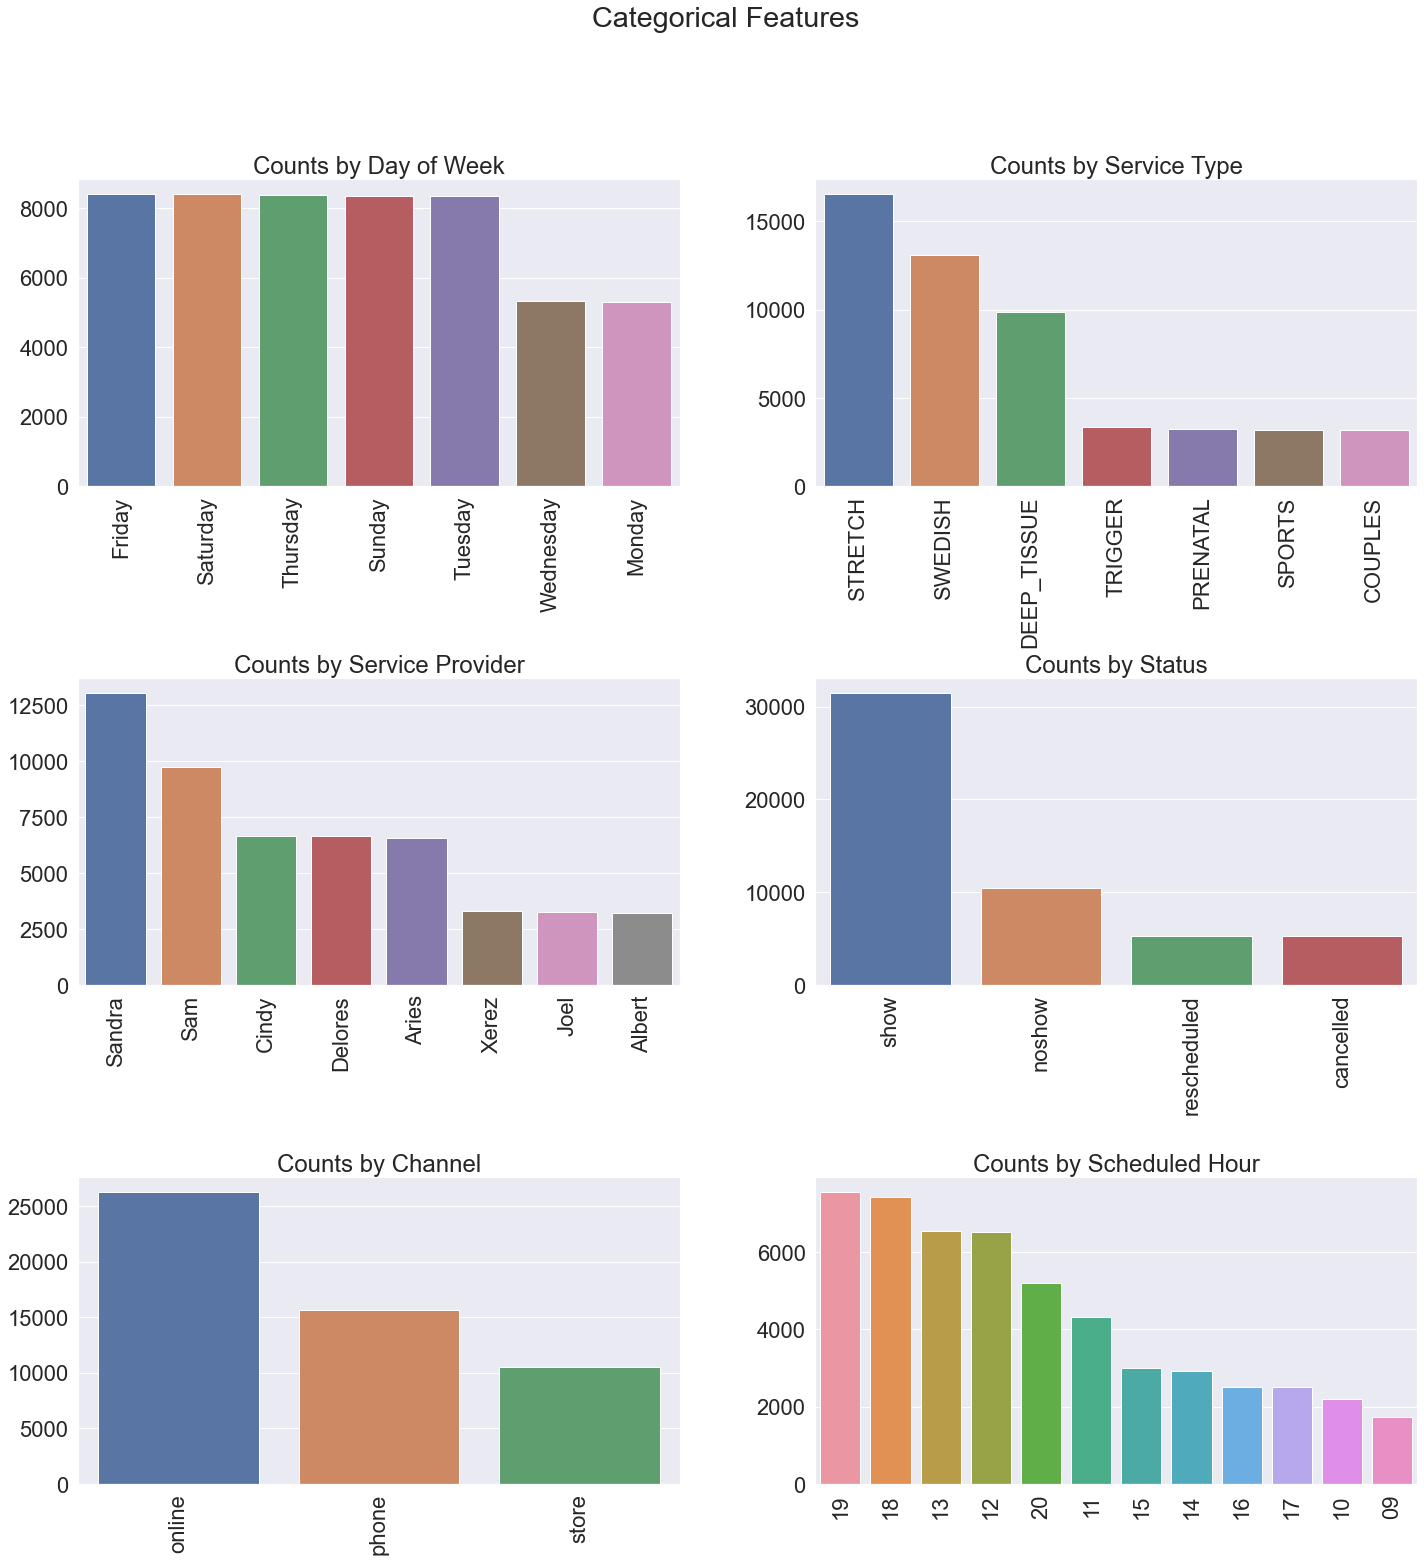

In [247]:
sns.set(font_scale = 2)

fig, ax = plt.subplots(3, 2, figsize=(24,24))
fig.suptitle('Categorical Features')
fig.subplots_adjust(hspace=0.625, wspace=0.225)

def add_subplot(feature, plot_x, plot_y, title):
    plot = sns.countplot(x=feature, data=df, ax=ax[plot_x, plot_y], order = df[feature].value_counts().index);
    plot.set_title(title)
    plot.set_xticklabels(plot.get_xticklabels(),rotation = 90)
    plot.set(xlabel=None, ylabel=None)
    
add_subplot('scheduled_day_of_week',0,0,"Counts by Day of Week")
add_subplot('service_type',0,1,"Counts by Service Type")
add_subplot('service_provider',1,0,"Counts by Service Provider")
add_subplot('status',1,1,"Counts by Status")
add_subplot('channel',2,0,"Counts by Channel")
add_subplot('scheduled_hour',2,1,"Counts by Scheduled Hour")

Let us observe weekly appointment reservation trends

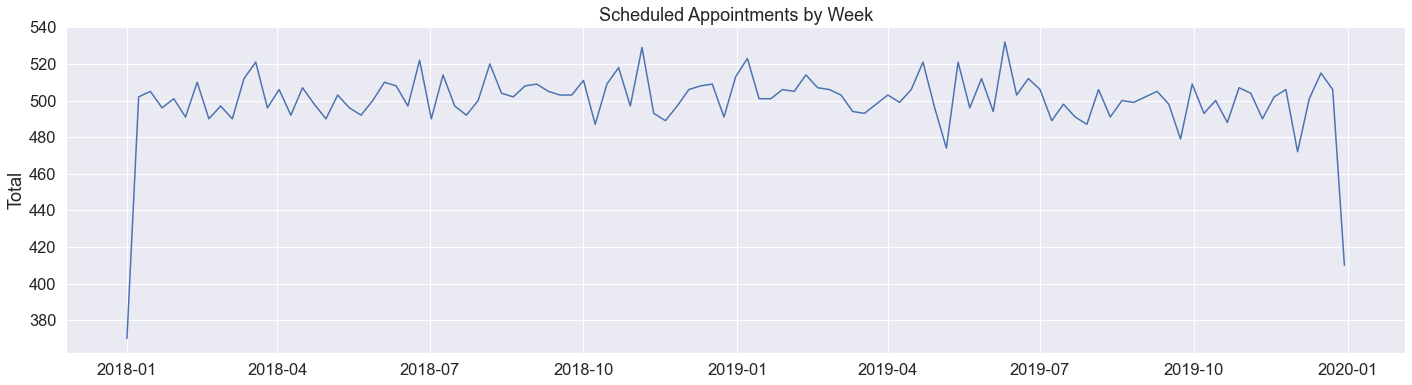

In [263]:
sns.set(font_scale = 1.5)

appointments = pd.DataFrame(df.resample('7D', on='scheduled_date').sum()['appointment_count'])
appointments.sort_index(inplace = True)

appointments.head()

fig, ax = plt.subplots(1, 1, figsize=(24,6))
plot = sns.lineplot(data = appointments, x='scheduled_date', y='appointment_count', ax=ax)
plot.set_title('Scheduled Appointments by Week')
plot.set(xlabel=None, ylabel="Total")
plt.show()


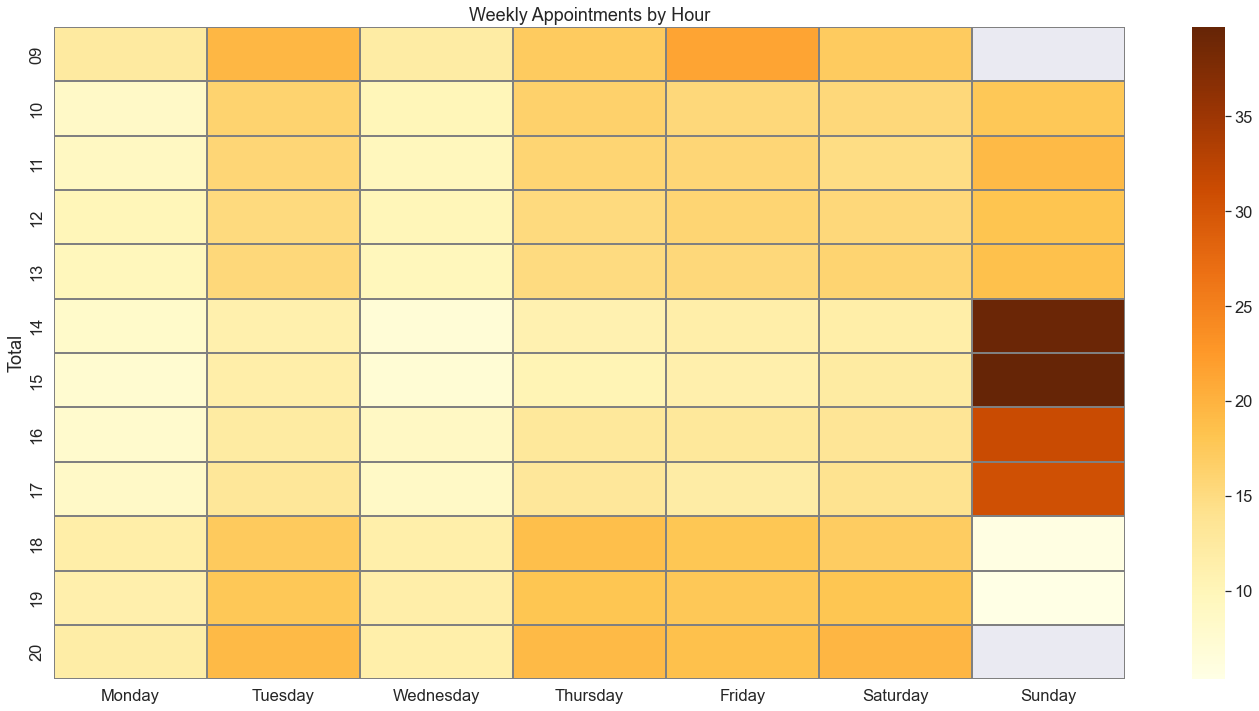

In [267]:
dow_appointments = df.groupby(['scheduled_hour','scheduled_day_of_week']).sum()['appointment_count'].groupby(level=0).apply(
    lambda x: 100* x/ x.sum()).unstack().loc[:,['Monday','Tuesday','Wednesday',
                                                'Thursday','Friday','Saturday',
                                                'Sunday']]
fig, ax = plt.subplots(1, 1, figsize=(24,12))
plot = sns.heatmap(dow_appointments, cmap='YlOrBr', linewidths=0.01, linecolor='gray')
plot.set_title('Weekly Appointments by Hour')
plot.set(xlabel=None, ylabel="Total")
plt.show()

#### Data Preparation

#### Modeling

#### Evaluation

#### Deployment